In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

import equationsH as eq

from scipy.integrate import solve_ivp

In [2]:
# shooting
# with polytropo
def shootingP(p_i, sig_i, Up_, Low_, rmax, rmin_=1e-03,
             L3_=1.5, c4_=-1/2, k_=100, L_=2, paso=1):
    """
    este es con las ecuaciones con polítropo
    N, g, a, b, p -> N, g, phi, phi', p
    """
    p0, sig0 = p_i, sig_i
    U0 = [1, 1, sig0, 0, p0]
    
    # IMPORTANT: it is not possible to find two event at same time
    def negSig(r, U, c): return U[2]
    def posSig(t, U, c): return U[-2]  # we used phi' as condition to find when phi grows
    # neg
    negSig.terminal = True; negSig.direction = -1
    # pos
    posSig.terminal = True; posSig.direction = 1
  
    while True:
        w_ = (Up_+Low_)/2
        c_ = [w_, c4_, L3_, L_, k_, p0]
        
        sol_ = solve_ivp(eq.ODE_eqP, [rmin_, rmax], U0, args=([c_]), events=(posSig, negSig))
        
        if sol_.t_events[0].size != 0:  # 0 -> no event, 1 -> happened the event
            # print('positivo')
            Low_ = w_
            rTemp_ = sol_.t_events[0]
        elif sol_.t_events[1].size != 0: 
            # print('negativo')
            Up_ = w_
            rTemp_ = sol_.t_events[1]
        else:  # if it not have event in all r-interval, the w is fine
            print('Encontrado', w_)
            return w_
        
        # checking the lim freq. 
        if abs((Up_-Low_)/2)<=1e-15:
            print('Maxima presición alcanzada', w_, 'radio', rTemp_)
            return w_
        
        
# shooting constante        
def shootingC(p_i, sig_i, Up_, Low_, rmax, rho_, rmin_=1e-03,
             L3_=1.5, c4_=-1/2, paso=1):
    """
    para rho=cte
    # N, g, a, b, p -> N, g, phi, phi', p
    """
    p0, sig0 = p_i, sig_i
    U0 = [1, 1, sig0, 0, p0]
    
    # IMPORTANT: it is not possible to find two event at same time
    def negSig(r, U, c): return U[2]
    def posSig(t, U, c): return U[-2]  # we used phi' as condition to find when phi grows
    # neg
    negSig.terminal = True; negSig.direction = -1
    # pos
    posSig.terminal = True; posSig.direction = 1
    
    while True:
        w_ = (Up_+Low_)/2   
        c_ = [w_, c4, L3, rho_, p0]
        
        sol_ = solve_ivp(eq.ODE_eq, [rmin_, rmax], U0, args=([c_]), events=(posSig, negSig))
        
        if sol_.t_events[0].size != 0:  # 0 -> no event, 1 -> happened the event
            # print('positivo')
            Low_ = w_
            rTemp_ = sol_.t_events[0]
        elif sol_.t_events[1].size != 0: 
            # print('negativo')
            Up_ = w_
            rTemp_ = sol_.t_events[1]
        else:  # if it not have event in all r-interval, the w is fine
            print('Encontrado', w_)
            return w_
        
        # checking the lim freq. 
        if abs((Up_-Low_)/2)<=1e-15:
            print('Maxima presición alcanzada', w_, 'radio', rTemp_)
            return w_

In [2]:
# mass definition
M = lambda r, g: 4*np.pi*(r*(1-1/g**2))

In [4]:
# Example with constant density 
start_time = time.time()
# N, g, a, b, p = U

# parameters

rmax = 20
L3 = 1.5
c4 = 1/2
rho = 0.01
p0 = 2.8
sig0 = 0.25

Up = 3.7
Low = 3.3

w = shootingC(p0, sig0, Up, Low, rmax, rho, rmin_=1e-01)
print("--- %s seconds ---" % (time.time() - start_time))

Maxima presición alcanzada 3.492097017216368 radio [16.61501963]
--- 5.128229856491089 seconds ---


In [5]:
# Computing with the previusly results

# N, g, a, b, p = U

# parameters
rmin = 1e-1
rmax = 17.1
L3 = 1.5
c4 = 1/2
rho = 0.01
p0 = 2.8
sig0 = 0.25

w = 3.492097017216368

# %% Define time spans, initial values, and constants
c = [w, c4, L3, rho, p0]  # w, c4, L3, rho
rspan = np.linspace(rmin, rmax, 300)
# N, g, a, b, p -> N, g, phi, phi', p
U0 = [1, 1, sig0, 0, p0]

def zeroP(r, U, c): return U[4]
#def zeroSig(r, U, c): return U[4]
zeroP.direction = -1
#zeroSig.terminal = True

sol = solve_ivp(eq.ODE_eq, [rspan[0], rspan[-1]], U0, t_eval=rspan, args=([c]),
               events=(zeroP))  # rtol = 1e-5

print(sol.t_events)

[array([16.25103182])]


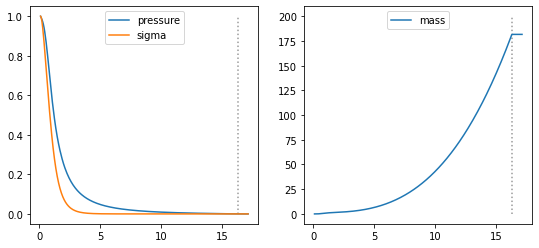

In [6]:
# Plotting the results
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9,4))

ax[0].plot(sol.t, sol.y[-1]/sol.y[-1][0], label='pressure')
ax[0].plot(sol.t, sol.y[2]/sol.y[2][0], label='sigma')

ax[0].vlines(x=sol.t_events, ymin=0, ymax=1, ls=':', alpha=0.4, color='black')
#ax[0].yscale('log')

ax[1].plot(sol.t, M(sol.t, sol.y[1]), label='mass')
ax[1].vlines(x=sol.t_events, ymin=0, ymax=200, ls=':', alpha=0.4, color='black')

ax[0].legend(loc='upper center')
ax[1].legend(loc='upper center')

In [7]:
# Example with polytropo
start_time = time.time()

# N, g, a, b, p = U

# parameters
rmin = 1e-3
rmax = 48
#L3 = 1.5
#c4 = -1/2
#k = 100
#L = 2 # gamma
p0 = 0.001
sig0 = 0.25


Up = 1.3
Low = 1.2

w = shootingP(p0, sig0, Up, Low, rmax, rmin_=1e-01, L3_=1.5, c4_=-1/2, k_=100, L_=2, paso=1)
print("--- %s seconds ---" % (time.time() - start_time))

Maxima presición alcanzada 1.2351568890609324 radio [41.65907937]
--- 3.9447648525238037 seconds ---


In [15]:
# Computing with the previusly results

# N, g, a, b, p = U

# parameters
rmin = 1e-1
rmax = 48
L3 = 1.5
c4 = -1/2
k = 100
L = 2 # gamma
p0 = 0.001
sig0 = 0.25

w = 1.2351568890609324

# %% Define time spans, initial values, and constants
c = [w, c4, L3, L, k, p0]
rspan = np.linspace(rmin, rmax, 300)
# N, g, a, b, p -> N, g, phi, phi', p
U0 = [1, 1, sig0, 0, p0]

def zeroP(r, U, c): return U[4]
#def zeroSig(r, U, c): return U[4]
zeroP.direction = -1
#zeroSig.terminal = True

sol = solve_ivp(eq.ODE_eqP, [rspan[0], rspan[-1]], U0, t_eval=rspan, args=([c]),
               events=(zeroP))  # rtol = 1e-5

print(sol.t_events)

[array([], dtype=float64)]


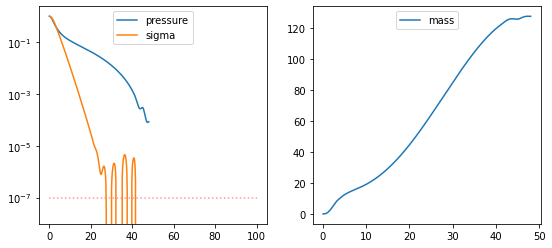

In [23]:
# Plotting the results
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9,4))

ax[0].plot(sol.t, sol.y[-1]/sol.y[-1][0], label='pressure')
ax[0].plot(sol.t, sol.y[2]/sol.y[2][0], label='sigma')

ax[0].vlines(x=sol.t_events, ymin=0, ymax=1, ls=':', alpha=0.4, color='black')
ax[0].hlines(y=p0/1e04, xmin=0, xmax=100, ls=':', alpha=0.4, color='red')
ax[0].set_yscale('log')

ax[1].plot(sol.t, M(sol.t, sol.y[1]), label='mass')
ax[1].vlines(x=sol.t_events, ymin=0, ymax=200, ls=':', alpha=0.4, color='black')

ax[0].legend(loc='upper center')
ax[1].legend(loc='upper center')

In [26]:
M(sol.t, sol.y[1])[-1]

127.58678908581548

## Old shooting version 

In [ ]:
# shooting

def shootingP(p_i, sig_i, Up_, Low_, rmax, rmin_=1e-03,
             L3_=1.5, c4_=-1/2, k_=100, L_=2, paso=1):
    """
    este es con las ecuaciones con polítropo
    """
    p0, sig0 = p_i, sig_i
    # N, g, a, b, p -> N, g, phi, phi', p
    U0 = [1, 1, sig0, 0, p0]
    
    rTemp_ = rmin_+paso
    while True:
        w_ = (Up_+Low_)/2
        
        c_ = [w_, c4_, L3_, L_, k_, p0]  # w, c4, L3, rho, p0
        
        sol_ = solve_ivp(eq.ODE_eqP, [rmin_, rTemp_], U0, args=([c_]))
        
        sigmaV_ = sol_.y[2]
        
        if (sigmaV_[-1] >= 2*sig0) or (sigmaV_[-1] >= sigmaV_[-2]):
            # positivo
            # print('positivo')
            Low_ = w_
        elif (sigmaV_[-1] <= -2*sig0) or (sigmaV_[-1] < 0):
            # negativo
            # print('negativo')
            Up_ = w_
        elif int(rTemp_) == int(rmax):
            print('Encontrado', w_, ' ', rTemp_)
            return w_
        else:
            rTemp_ += paso
        
        # revisando que no lo encuentre
        if abs((Up_-Low_)/2)<=1e-15:
            print('Maxima presición alcanzada', w_, 'radio', rTemp_)
            return w_
        
        
# shooting constante        
def shootingC(p_i, sig_i, Up_, Low_, rmax, rho_, rmin_=1e-03,
             L3_=1.5, c4_=-1/2, paso=1):
    """
    para rho=cte
    """
    p0, sig0 = p_i, sig_i
    # N, g, a, b, p -> N, g, phi, phi', p
    U0 = [1, 1, sig0, 0, p0]
    
    rTemp_ = rmin_+paso
    while True:
        w_ = (Up_+Low_)/2
        
        c_ = [w_, c4, L3, rho_, p0]  # w, c4, L3, rho, p0
        
        sol_ = solve_ivp(eq.ODE_eq, [rmin_, rTemp_], U0, args=([c_]))
        
        sigmaV_ = sol_.y[2]
        
        if (sigmaV_[-1] >= 2*sig0) or (sigmaV_[-1] >= sigmaV_[-2]):
            # positivo
            # print('positivo')
            Low_ = w_
        elif (sigmaV_[-1] <= -2*sig0) or (sigmaV_[-1] < 0):
            # negativo
            # print('negativo')
            Up_ = w_
        elif int(rTemp_) == int(rmax):
            print('Encontrado', w_, ' ', rTemp_)
            return w_
        else:
            rTemp_ += paso
        
        # revisando que no lo encuentre
        if abs((Up_-Low_)/2)<=1e-15:
            print('Maxima presición alcanzada', w_, 'radio', rTemp_)
            return w_